AI Programming - SW Lee

# Lab 04: AlexNet for ImageNet Challenge (ILSVRC)
## Exercise: Image Classification

Load Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # 케라스 백엔드를 텐서플로우로 설정
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU') # GPU가 사용 가능한지 확인
print("Num GPUs Available: ", len(gpus)) # 사용 가능한 GPU 개수 출력

Num GPUs Available:  1


Prepare Datasets

In [2]:
dataset = 'cifar10' # cifar10 또는 imagenette 중 선택

if dataset == 'cifar10':  # CIFAR10 데이터셋을 사용할 경우
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...

    # batch_size=None으로 설정하면 데이터셋을 로드할 때 배치 크기를 지정할 수 있음
    # shuffle_files=True로 설정하면 데이터셋을 로드할 때 파일을 섞음
    # as_supervised=True로 설정하면 데이터셋을 (input, label) 쌍으로 로드함
    # with_info=True로 설정하면 데이터셋의 정보를 함께 로드함
    # ds_train : 40000개의 훈련 이미지
    # ds_test : 10000개의 테스트 이미지
    # ds_val : 10000개의 검증 이미지
    # ds_info : 데이터셋의 정보

    # train set의 80%를 훈련 데이터셋으로 사용하고 나머지 20%를 검증 데이터셋으로 사용, test set은 그대로 사용
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)

elif dataset == 'imagenette': # Imagenette 데이터셋을 사용할 경우
    # Imagenette is a subset of 10 easily classified classes from Imagenet
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

    # train set은 다 쓰고 validation set을 50%만 사용하여 test set을 만들고 나머지 50%를 validation set으로 사용
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features) # 데이터셋의 특징 출력
print(ds_info.splits) # 데이터셋의 분할 정보 출력
print(ds_info.splits['train'].num_examples) # 훈련 데이터셋의 이미지 개수 출력

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
{'train': <SplitInfo num_examples=50000, num_shards=1>, 'test': <SplitInfo num_examples=10000, num_shards=1>}
50000


In [3]:
n_channels = ds_info.features['image'].shape[-1] # 이미지의 채널 수

if dataset == 'imagenette': # Imagenette 데이터셋의 클래스 이름
    # 10개의 클래스 이름
    classes = ['tench', 'English springer', 'cassette player', 'chain saw',
               'church', 'French horn', 'garbage truck', 'gas pump',
               'golf ball', 'parachute']
else:
    # CIFAR10 데이터셋의 클래스 이름
    classes = ds_info.features['label'].names
# 클래스 개수
n_classes = ds_info.features['label'].num_classes

n_train = len(ds_train) # 훈련 데이터셋의 이미지 개수
n_test = len(ds_test) # 테스트 데이터셋의 이미지 개수
n_val = len(ds_val) # 검증 데이터셋의 이미지 개수

print(n_train,n_test,n_val) # 훈련, 테스트, 검증 데이터셋의 이미지 개수 출력

40000 10000 10000


Show a Sample Data

Image demension: (32, 32, 3) , label: 4


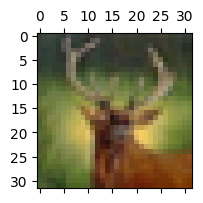

The picture is deer


In [4]:
idx = np.random.randint(n_train-1)  # n_test-1 사이의 랜덤한 인덱스 선택

for element in ds_train.skip(idx).take(1): # idx 이후의 이미지 중 하나를 선택
    image, label = element # 이미지와 레이블

print('Image demension:', image.shape, ', label:',label.numpy()) # 이미지의 차원과 레이블 출력
dimage = tf.reshape(image, image.shape)  # 이미지 형태를 변경하지만 형태는 그대로 유지, 즉 dimage=image와 같음
plt.figure(figsize=(2,2))  # 이미지의 크기 설정
plt.matshow(dimage, 1) # 행렬에 있는 값을 색으로 표시
plt.show()# 이미지 출력
print('The picture is', classes[label]) # 이미지의 클래스 출력

Building Input Data Pipelines

In [5]:
def tfds_4_NET(image, label): # 이미지 전처리 함수
    # bilinear : 이웃한 4개의 픽셀을 사용하여 새로운 픽셀을 생성
    # tf.image.resize의 첫번째 인자는 이미지, 두번째 인자는 이미지 크기, 세번째 인자는 보간법
    # 이미지 크기를 227x227로 변경하고 픽셀 값을 0~1 사이로 정규화
    # image/255 : 이미지의 픽셀 값을 0~1 사이로 정규화
    image = tf.image.resize((image / 255), [227,227], method='bilinear') # 이미지 크기를 227x227로 변경
    label = tf.one_hot(label, n_classes)  # 레이블을 원-핫 인코딩으로 변경

    return image, label # 전처리된 이미지와 레이블 반환

In [6]:
n_batch = 64 # 배치 크기

# ds_train.map : 데이터셋의 각 요소에 함수를 적용
# 첫번째 인자 : 이미지 전처리 함수, 두번째 인자 : 병렬처리 수행
# tf.data.AUTOTUNE : 데이터셋의 처리 순서를 런타임에 동적으로 결정
dataset = ds_train.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE) # 데이터셋 전처리
# shuffle : 데이터셋을 섞음, buffer_size : 섞을 데이터의 크기
# batch : 데이터셋을 배치로 만듬, batch_size : 배치 크기
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch) # 데이터셋 섞고 배치 생성

valiset = ds_val.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE) # 검증 데이터셋 전처리
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)  # 검증 데이터셋 섞고 배치 생성

testset = ds_test.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE) # 테스트 데이터셋 전처리
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch) # 테스트 데이터셋 섞고 배치 생성

### Network Definition of AlexNet with Keras Sequential API



In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# AlexNet 모델 정의
AlexNet = keras.Sequential([
    # Input Layer
    layers.InputLayer(input_shape=(227, 227, 3)),  # 입력 이미지 크기 설정 (227x227 픽셀, 3채널 RGB)

    # Layer 1: Conv2D + BatchNormalization + MaxPooling2D

    # Conv2D : 96개의 필터, 커널 크기 11x11, 스트라이드 4x4, 활성화 함수 ReLU
    # 커널은 이미지의 특징을 추출하는 역할을 함
    # 스트라이드는 커널이 이동하는 간격을 의미
    # 활성화 함수 ReLU는 음수를 0으로 만들어주는 역할을 함
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Layer 2: Conv2D + BatchNormalization + MaxPooling2D
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Layer 3: Conv2D
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),

    # Layer 4: Conv2D
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),

    # Layer 5: Conv2D + BatchNormalization + MaxPooling2D
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Flatten Layer: Flatten the data for the dense layers
    layers.Flatten(),

    # Layer 6: Dense + Dropout
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    # Layer 7: Dense + Dropout
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer: Dense layer for classification
    layers.Dense(10, activation='softmax')  # Assuming 10 classes for classification
])

# Model summary to display the architecture
AlexNet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

**Expected Outputs**

```
┏--------------------------------------┳-----------------------------┳-----------------┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡--------------------------------------╇-----------------------------╇-----------------┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization_2                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└--------------------------------------┴-----------------------------┴-----------------┘
 Total params: 58,324,746 (222.49 MB)
 Trainable params: 58,323,530 (222.49 MB)
 Non-trainable params: 1,216 (4.75 KB)
 ```

### Training the Model

In [8]:
opt = keras.optimizers.Adam(learning_rate=0.001) # Adam optimizer 사용, 학습률 0.001

# 모델 컴파일
# Adam optimizer 사용
# 손실함수는 다중 클래스 분류에 사용되는 categorical_crossentropy 사용
# 정확도를 측정하기 위해 acc 사용
# jit_compile=True로 설정하면 모델을 컴파일할 때 최적화를 수행
AlexNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'], jit_compile=True)

In [9]:
n_epochs = 10 # iteration 횟수

 # 모델 훈련
 # 훈련 데이터셋, 검증 데이터셋, iteration 횟수, 배치 크기 설정
 # verbose=1로 설정하면 훈련 과정을 출력
results = AlexNet.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                   validation_data=valiset, validation_batch_size=n_batch,
                   verbose=1)

Epoch 1/10
625/625 [==============================] - 162s 224ms/step - loss: 2.3949 - acc: 0.2565 - val_loss: 1.8779 - val_acc: 0.3287
Epoch 2/10
625/625 [==============================] - 140s 224ms/step - loss: 1.7909 - acc: 0.3400 - val_loss: 1.6701 - val_acc: 0.3939
Epoch 3/10
625/625 [==============================] - 139s 222ms/step - loss: 1.6324 - acc: 0.4082 - val_loss: 2.3827 - val_acc: 0.2328
Epoch 4/10
625/625 [==============================] - 138s 220ms/step - loss: 1.5092 - acc: 0.4543 - val_loss: 1.8217 - val_acc: 0.3720
Epoch 5/10
625/625 [==============================] - 139s 222ms/step - loss: 1.4010 - acc: 0.5007 - val_loss: 1.4696 - val_acc: 0.4791
Epoch 6/10
625/625 [==============================] - 138s 221ms/step - loss: 1.2840 - acc: 0.5491 - val_loss: 1.8018 - val_acc: 0.3658
Epoch 7/10
625/625 [==============================] - 139s 222ms/step - loss: 1.1901 - acc: 0.5871 - val_loss: 1.2298 - val_acc: 0.5963
Epoch 8/10
625/625 [============================

Plot Convergence Graph

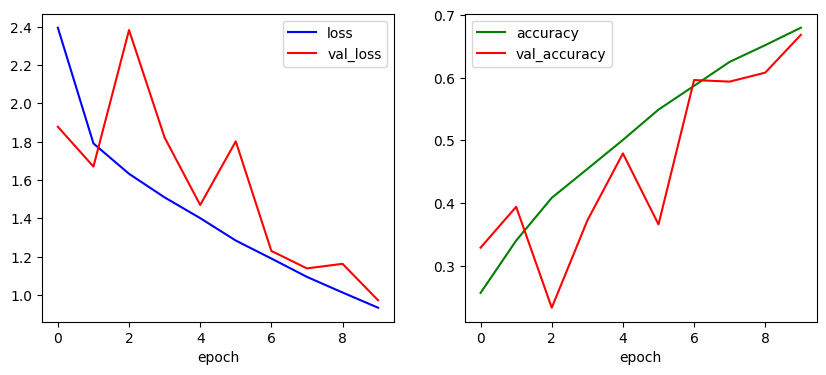

In [10]:
# plot loss and accuracy
plt.figure(figsize=(10,4)) # 그래프의 크기 설정
plt.subplot(1,2,1) # 1행 2열 중 첫번째 그래프
plt.plot(results.history['loss'], 'b-', label='loss') # 훈련 손실 그래프
plt.plot(results.history['val_loss'], 'r-', label='val_loss') # 검증 손실 그래프
plt.xlabel('epoch') # x축 레이블
plt.legend() # 범례

plt.subplot(1,2,2) # 1행 2열 중 두번째 그래프
plt.plot(results.history['acc'], 'g-', label='accuracy') # 훈련 정확도 그래프
plt.plot(results.history['val_acc'], 'r-', label='val_accuracy') # 검증 정확도 그래프
plt.xlabel('epoch') # x축 레이블
plt.legend() # 범례

plt.show() # 그래프 출력

Evaluate Model Performance

In [11]:
AlexNet.evaluate(testset) # 테스트 데이터셋으로 모델 평가

157/157 [==============================] - 12s 75ms/step - loss: 0.9662 - acc: 0.6759


[0.9661840200424194, 0.6759000420570374]

### Test Model with a Random Sample


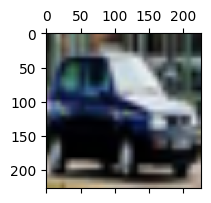

1/1 [==============================] - 0s 32ms/step
My prediction is automobile
Actual image is  automobile


In [13]:
idx = np.random.randint(n_test-1) # n_test-1 사이의 랜덤한 인덱스 선택

for element in ds_test.skip(idx).take(1): # idx 이후 이미지 중 1개 선택
    img, lbl = element # 이미지와 레이블
    X_test, y_test = tfds_4_NET(img, lbl) # 이미지 전처리

X_test = tf.expand_dims(X_test, axis=0) # 이미지 차원 확장

dimage = np.array(X_test[0]) # 이미지 배열로 변환
plt.figure(figsize=(2,2))  # 이미지의 크기 설정
plt.matshow(dimage, fignum=1) # 행렬에 있는 값을 색으로 표시
plt.show() # 이미지 출력

outt_4 = AlexNet.predict(X_test) # 이미지를 모델에 입력하여 예측
p_pred = np.argmax(outt_4, axis=-1) # 예측 결과

print('My prediction is ' + classes[p_pred[0]]) # 예측 결과 출력
print('Actual image is  ' + classes[tf.argmax(y_test, -1)]) # 실제 결과 출력

(c) 2024 SW Lee